In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [2]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

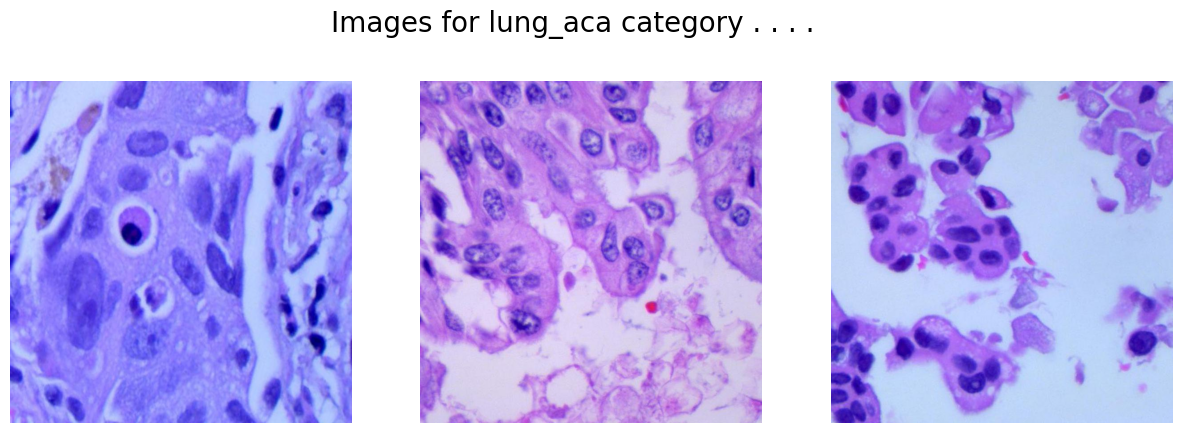

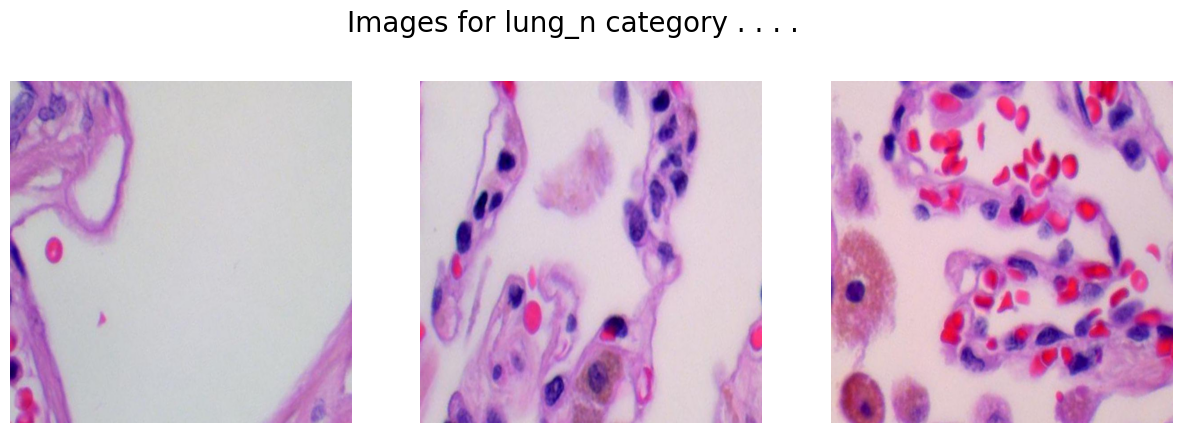

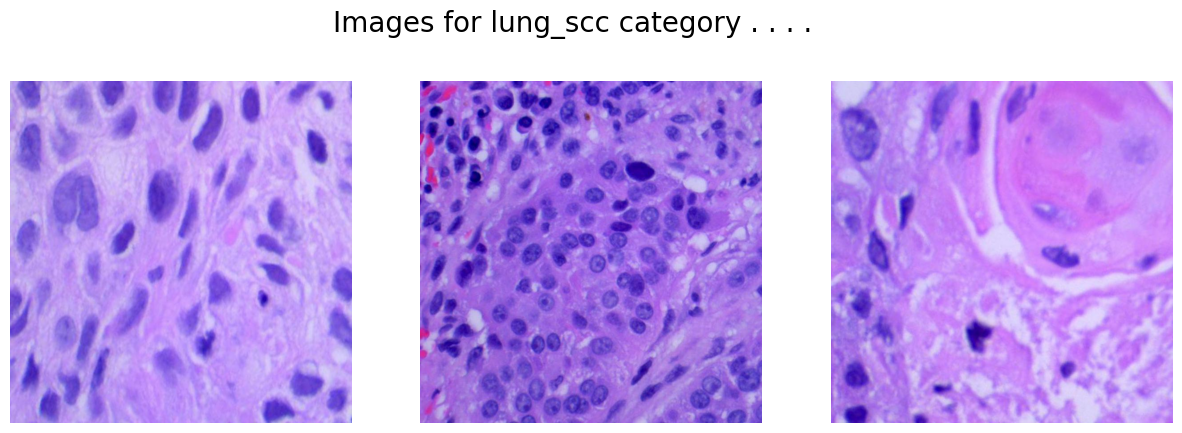

In [14]:
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [15]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10 
BATCH_SIZE = 64

In [16]:
X = []
Y = []

for i, cat in enumerate(classes):
	images = glob(f'{path}/{cat}/*.jpeg')

	for image in images:
		img = cv2.imread(image)
		
		X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
		Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [18]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [2]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


NameError: name 'keras' is not defined

In [21]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [23]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7866 - loss: 0.5058 - val_accuracy: 0.3353 - val_loss: 6.5447 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.8935 - loss: 0.2602 - val_accuracy: 0.4270 - val_loss: 2.8955 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9264 - loss: 0.1836 - val_accuracy: 0.3317 - val_loss: 7.0100 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9392 - loss: 0.1604
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9392 - loss: 0.1605 - val_accuracy: 0.4943 - val_loss: 7.1596 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9631 - loss: 0.1006 - val_accuracy: 0.7463 - val_loss: 0.8591 - learning_rate: 5.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9803 - loss: 0

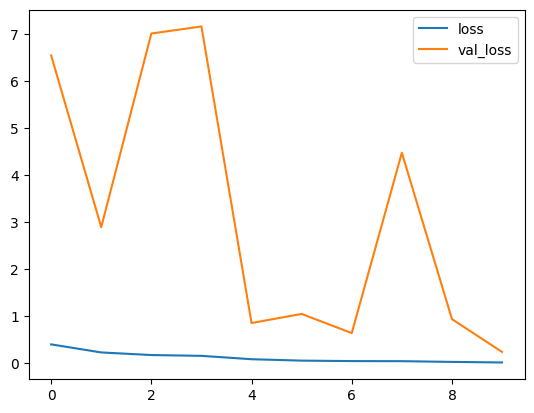

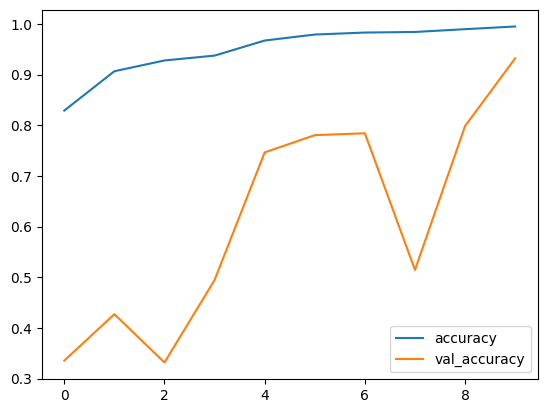

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [25]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step


In [26]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 832,    0,  155],
       [  19,  958,    0],
       [  30,    0, 1006]], dtype=int64)

In [27]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.94      0.84      0.89       987
      lung_n       1.00      0.98      0.99       977
    lung_scc       0.87      0.97      0.92      1036

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000



In [1]:
model.save('models/model_lung.keras')

NameError: name 'model' is not defined